# SkimLit exercises
Exercises from @mrdbourdke course, all solution are either code-alongs (if already created) or proposed my myself.

## Exercise 1
Train `model_5` from notebook 09 on all of the data in the training dataset as many epochs until it stops improving. Since this might take a while, consider using:
* `tf.keras.callbacks.ModelCheckpoint` to save weights of the best model trained
* `tf.keras.callbacks.EarlyStopping` to stop the model from training once the validation less has stopped improving for approx. 3 epochs

### Confirm GPU access

In [1]:
!nvidia -smi

/bin/bash: nvidia: command not found


### Get the data

In [2]:
# Clone the GitHub repo and 
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 11.33 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Get the full, 200k dataset
data_dir = "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

In [4]:
# Check the filenames in the directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip']

In [5]:
# Download helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-04-24 20:18:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-24 20:18:07 (52.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [6]:
# Unzipping the data
from helper_functions import unzip_data
unzip_data("/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip")

### Preprocess the data

In [7]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (text file) and returns the lines of text as a list.

  Args:
    filename: string, contains the target filepath

  Returns:
    A list of strins with one string per line from the target filename
  """

  with open(filename, 'r') as f:
    return f.readlines()

In [8]:
# Reading in the training lines
train_lines = get_lines('train.txt')
train_lines[:10]

['###24491034\n',
 'BACKGROUND\tThe emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n',
 'BACKGROUND\tThis paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .\n',
 'METHODS\tThis study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .\n',
 "METHODS\tThe intervention group will participate in the online group program ` Positive Outlook ' .\n",
 'METHODS\tThe program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with HIV in daily life .\n',
 'METHODS\tParticipants will access the program f

In [9]:
# Get the total number of lines
len(train_lines)

2593169

In [10]:
# Function to preprocess the data to desired format
def preprocess_text_with_linenumbers(filename):
  """
  Returns a list of dictionaries of abstract RCT line data. Takes in the filename,
  reads its content and works through each line extracting all necessary data to
  be returned,

  Args:
    filename: string, contains a RCT data 

  Returns:
    abstract_samples: dictionary, with data such as 'target', 'text',
      'line_number' and 'total_lines' per each abstract
  """
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"): # check for the ID of an abastract
      abstract_id = line
      abstract_lines = "" # reset the abstract string so it's empty for new one

    elif line.isspace(): # check if the line is the new line
      abstract_line_split = abstract_lines.splitlines() # split the lines into new lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split the text from the target label
        line_data['target'] = target_text_split[0] # get the target label
        line_data['text'] = target_text_split[1].lower() # get the text in lowered version
        line_data['line_number'] = abstract_line_number # get the number of a particular line from enumerate operator
        line_data['total_lines'] = len(abstract_line_split)-1 # how many total lines are there in each abstract

        abstract_samples.append(line_data) # add the data to the samples list

    else: # if the above are not met, the line contains labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [11]:
# Get the data into the memory
%%time
train_samples = preprocess_text_with_linenumbers('train.txt')
val_samples = preprocess_text_with_linenumbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_linenumbers(data_dir + 'test.txt')
print(len(train_samples), len(val_samples), len(test_samples))

2211861 28932 29493
CPU times: user 5 s, sys: 1.3 s, total: 6.3 s
Wall time: 6.38 s


In [12]:
# Check the first samples from training data
train_samples[:15]

[{'target': 'BACKGROUND',
  'text': 'the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
  'line_number': 0,
  'total_lines': 10},
 {'target': 'BACKGROUND',
  'text': 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
  'line_number': 1,
  'total_lines': 10},
 {'target': 'METHODS',
  'text': 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
  'line_number': 2,
  'total_lines': 10},
 {'target': 'METHODS',
  'text': "the intervention group will participate in the online group program ` positive outlook ' .",
  'line_number': 3,
  'total_lines': 10},
 {'target': 'METHODS',
  '

In [13]:
# Placing the data in Pandas DataFrame
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(15)

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10
5,METHODS,participants will access the program for a min...,5,10
6,METHODS,primary outcomes are domain specific self-effi...,6,10
7,METHODS,"secondary outcomes include : depression , anxi...",7,10
8,METHODS,"data collection will take place at baseline , ...",8,10
9,CONCLUSIONS,results of the positive outlook study will pro...,9,10


### Small portion of EDA

<Axes: >

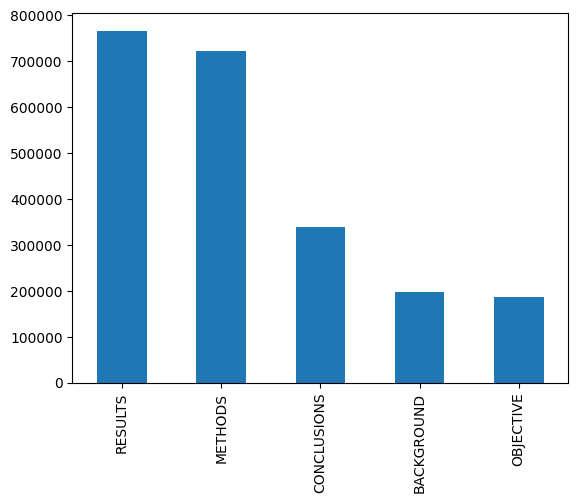

In [14]:
# Distribution of training labels
train_df['target'].value_counts().plot(kind='bar')

<Axes: ylabel='Frequency'>

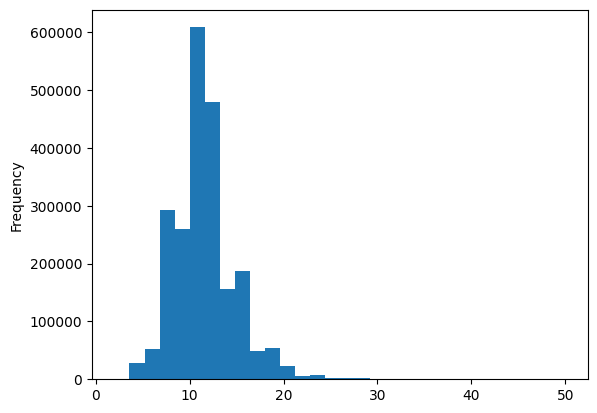

In [15]:
# Checking the number of lines per abstract
train_df.total_lines.plot.hist(bins=30)

### Getting the list of sentences

In [16]:
# Extracting the lines from DataFrames
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()
print(len(train_sentences))

2211861


### Encode the labels
Both one-hot-encoded and label encoded (numerical value)

In [17]:
# One-hot encode labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit(test_df['target'].to_numpy().reshape(-1, 1))

# Check one set of labels
train_labels_one_hot[:20]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [18]:
# Label encode labels (numerical values)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# Check the labels
train_labels_encoded[:20]

array([0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 2, 2, 2, 4, 4, 4, 4, 4])

In [19]:
# Get class names and number of classes
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Create a character-level tokenizer

In [20]:
# Look again at the exemplary sentences
train_sentences[:5]

['the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
 "the intervention group will participate in the online group program ` positive outlook ' .",
 'the program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with hiv in daily life .']

In [21]:
# Function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Check the function
import random
target_sentence = split_chars(random.choice(train_sentences))
split_chars(target_sentence)

'w   h   o   l   e       b   o   d   y       g   l   u   c   o   s   e       d   i   s   p   o   s   a   l       (       w   l   o   s   s       @       +       /       -       @       v   s   .       @       +       /       -       @       ,       r   t       +       w   l   o   s   s       @       +       /       -       @       v   s   .       @       +       /       -       @       m   g   /   k   g       o   f       f   f   m   /   m   i   n       )       d   i   d       n   o   t       c   h   a   n   g   e       i   n       e   i   t   h   e   r       g   r   o   u   p       .'

In [22]:
# Split all the data into char tokens
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[1])

t h i s   p a p e r   d e s c r i b e s   t h e   d e s i g n   a n d   e v a l u a t i o n   o f   p o s i t i v e   o u t l o o k   ,   a n   o n l i n e   p r o g r a m   a i m i n g   t o   e n h a n c e   t h e   s e l f - m a n a g e m e n t   s k i l l s   o f   g a y   m e n   l i v i n g   w i t h   h i v   .


In [23]:
# Average char length
import numpy as np
char_len = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_len)
mean_char_len

147.82646377869133

(array([1.73008e+05, 7.09771e+05, 7.07576e+05, 3.79589e+05, 1.53041e+05,
        5.52560e+04, 1.99370e+04, 7.95500e+03, 3.07000e+03, 1.35700e+03,
        6.31000e+02, 3.15000e+02, 1.49000e+02, 8.50000e+01, 5.60000e+01,
        3.10000e+01, 1.20000e+01, 6.00000e+00, 8.00000e+00, 4.00000e+00,
        1.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 6.01333333e+01, 1.19266667e+02, 1.78400000e+02,
        2.37533333e+02, 2.96666667e+02, 3.55800000e+02, 4.14933333e+02,
        4.74066667e+02, 5.33200000e+02, 5.92333333e+02, 6.51466667e+02,
        7.10600000e+02, 7.69733333e+02, 8.28866667e+02, 8.88000000e+02,
        9.47133333e+02, 1.00626667e+03, 1.06540000e+03, 1.12453333e+03,
        1.18366667e+03, 1.24280000e+03, 1.30193333e+03, 1.36106667e+03,
        1.42020000e+03, 1.47933333e+03, 1.53846667e+03, 1.59760000e+03,
        1.65673333e+03, 1.71586667e+03, 1.77500000e+03])

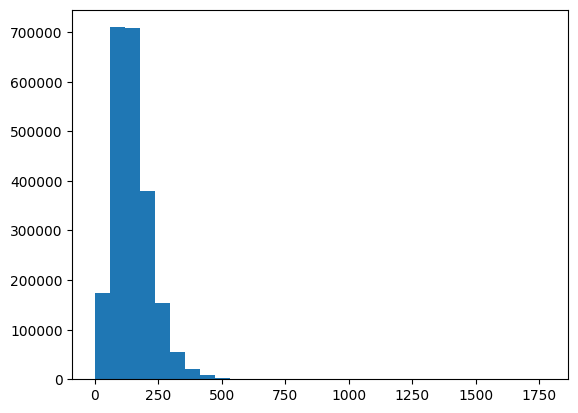

In [24]:
# Distribution of character level length
import matplotlib.pyplot as plt
plt.hist(char_len, bins=30)

In [25]:
# Check the 95 percentile
output_seq_char_len = int(np.percentile(char_len, 95))
output_seq_char_len

284

In [26]:
# Get all of the keyboard characters into one variable
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [27]:
# Create character-level token vectorizer instance
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
NUM_CHAR_TOKENS = len(alphabet)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS+2,
                                    output_sequence_length=output_seq_char_len,
                                    standardize=None,
                                    name='char_vectorizer')

In [28]:
# Create another instance of dataset for adapting the layer
import tensorflow as tf
train_char_adapt = tf.data.Dataset.from_tensor_slices(train_chars).batch(128).prefetch(tf.data.AUTOTUNE)
train_char_adapt

<_PrefetchDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [29]:
# Adapt the layer to characters
%%time
char_vectorizer.adapt(train_char_adapt)

CPU times: user 44.2 s, sys: 1.41 s, total: 45.6 s
Wall time: 41.4 s


In [30]:
# Check the vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of chars: {len(char_vocab)}")
print(f"Most popular chars: {char_vocab[:5]}")
print(f"Least popular chars: {char_vocab[-5:]}")

Number of chars: 60
Most popular chars: ['', '[UNK]', 'e', 't', 'a']
Least popular chars: ['!', '|', '\\', '^', '"']


In [31]:
# Test the layer
random_chars = random.choice(train_chars)
print(f"Random charred sentence:\n {random_chars}\n")
vectorized_chars = char_vectorizer(random_chars)
print(f"Vectorized, charred sentence:\n {vectorized_chars}\n")
print(f"Shape of vectorized, charred text:\n {vectorized_chars.shape}")

Random charred sentence:
 w i t h i n   a   r a n d o m i s e d   c o n t r o l l e d   t r i a l   ,   a   s t a t u t o r y   h e a l t h   i n s u r a n c e   e v a l u a t e d   a   p r o g r a m m e   a i m e d   a t   t h e   p r e v e n t i o n   o f   a c t i v i t y   l i m i t a t i o n s   a n d   r e s t r i c t i o n s   o f   s o c i a l   p a r t i c i p a t i o n   i n   p a t i e n t s   w i t h   t y p e   @   d i a b e t e s   .

Vectorized, charred sentence:
 [21  5  3 13  5  6  4  8  4  6 10  7 15  5  9  2 10 12  7  6  3  8  7 11
 11  2 10  3  8  5  4 11 25  4  9  3  4  3 16  3  7  8 20 13  2  4 11  3
 13  5  6  9 16  8  4  6 12  2  2 22  4 11 16  4  3  2 10  4 14  8  7 18
  8  4 15 15  2  4  5 15  2 10  4  3  3 13  2 14  8  2 22  2  6  3  5  7
  6  7 17  4 12  3  5 22  5  3 20 11  5 15  5  3  4  3  5  7  6  9  4  6
 10  8  2  9  3  8  5 12  3  5  7  6  9  7 17  9  7 12  5  4 11 14  4  8
  3  5 12  5 14  4  3  5  7  6  5  6 14  4  3  5  2  6  3  9 21  5  3 13
  3 2

### Character-level embedding layer

In [32]:
# Create embedding layer
char_embed = tf.keras.layers.Embedding(input_dim=len(char_vocab), # number of different chars
                                       output_dim=25, # as stated in the paper
                                       mask_zero=True,
                                       name='char_embed')

In [33]:
# Test the layer
print(f"Charred text:\n {random_chars}\n")
embedded_chars = char_embed(vectorized_chars)
print(f"Vectorized, embedded charred text:\n {embedded_chars}\n")
print(f"Shape of the output:\n {embedded_chars.shape}")

Charred text:
 w i t h i n   a   r a n d o m i s e d   c o n t r o l l e d   t r i a l   ,   a   s t a t u t o r y   h e a l t h   i n s u r a n c e   e v a l u a t e d   a   p r o g r a m m e   a i m e d   a t   t h e   p r e v e n t i o n   o f   a c t i v i t y   l i m i t a t i o n s   a n d   r e s t r i c t i o n s   o f   s o c i a l   p a r t i c i p a t i o n   i n   p a t i e n t s   w i t h   t y p e   @   d i a b e t e s   .

Vectorized, embedded charred text:
 [[ 0.00806284  0.02347516  0.03082203 ...  0.04086911  0.01036232
  -0.01749799]
 [ 0.0459574  -0.03510658  0.04754191 ...  0.0481076  -0.02160986
  -0.00659654]
 [ 0.04983182  0.04965127  0.02546177 ...  0.04144483 -0.00993643
  -0.00341029]
 ...
 [-0.02895076 -0.01228277  0.00768963 ... -0.04834611 -0.01552115
  -0.01101763]
 [-0.02895076 -0.01228277  0.00768963 ... -0.04834611 -0.01552115
  -0.01101763]
 [-0.02895076 -0.01228277  0.00768963 ... -0.04834611 -0.01552115
  -0.01101763]]

Shape of the output:
 (284, 2

### Create positional embeddings

In [34]:
# Check how many different line numbers are in the dataset
train_df['line_number'].value_counts()

0     190654
1     190654
2     190654
3     190644
4     190357
5     189080
6     185551
7     177967
8     164187
9     143835
10    117871
11     90168
12     64864
13     44350
14     29186
15     18785
16     11803
17      7392
18      4688
19      3030
20      1925
21      1268
22       814
23       564
24       398
25       288
26       214
27       159
28       118
29        88
30        64
31        55
32        42
33        34
34        21
35        17
36        12
37         9
40         6
38         6
39         6
41         5
42         5
43         5
44         4
45         4
46         3
47         2
48         2
49         2
50         1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

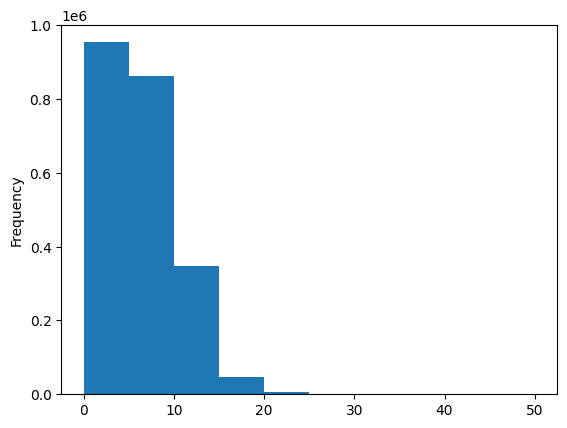

In [35]:
# Plot the distribution
train_df.line_number.plot.hist()

In [36]:
# Check the 98th percentile
line_number_depth = int(np.percentile(train_df['line_number'], 98))
line_number_depth

15

In [37]:
# One hot encode the data
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'], depth=line_number_depth)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'], depth=line_number_depth)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'], depth=line_number_depth)
train_line_numbers_one_hot[:15]

<tf.Tensor: shape=(15, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [38]:
# Now onto the total_lines...
train_df['total_lines'].value_counts()

10    304733
11    303648
12    266682
9     259640
13    212296
8     183168
14    156015
15    111712
7     110240
16     74987
6      53088
17     48672
18     31502
19     22100
5      21174
20     13797
21      9988
4       6385
22      5750
23      3984
24      2750
25      1924
26      1485
27      1148
3       1148
28       870
29       720
33       442
31       416
30       279
32       264
35       180
34       140
37       114
36       111
50        51
49        50
46        47
45        46
43        44
40        41
2         30
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

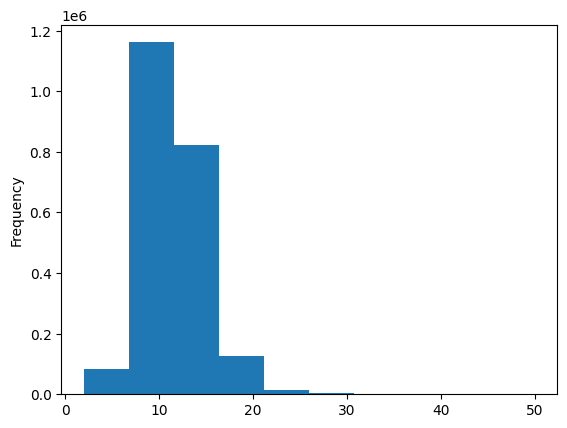

In [39]:
# Distribution
train_df['total_lines'].plot.hist()

In [40]:
# 98th percentile
total_lines_depth = int(np.percentile(train_df['total_lines'], 98))
total_lines_depth

20

In [41]:
# One hot encode the features
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'], depth=total_lines_depth)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'], depth=total_lines_depth)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'], depth=total_lines_depth)
train_total_lines_one_hot[:15]

<tf.Tensor: shape=(15, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
     

### Get a Universal Sentence Encoder layer ftom TF Hub

In [42]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name='universal_sentence_encoder')

### Build a model
At last, after all this preparation...

In [43]:
# 1. Token inputs
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line number inputs
line_number_inputs = tf.keras.layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
line_number_outputs = tf.keras.layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=line_number_outputs)

# 4. Total lines inputs
total_lines_inputs = tf.keras.layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
total_lines_outputs = tf.keras.layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=total_lines_outputs)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = tf.keras.layers.Concatenate(name='char_token_embedding')([char_model.output,
                                                                                token_model.output])
combined_dense = tf.keras.layers.Dense(256, activation='relu')(combined_embeddings)
combined_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)

# 6. Triple embedding with line number, total lines and combined char&token embeddings
triple_embedding = tf.keras.layers.Concatenate(name='triple_embedding')([line_number_model.output,
                                                                         total_lines_model.output,
                                                                         combined_dropout])

# 7. Create the final output layer
output_layer = tf.keras.layers.Dense(5, activation='softmax', name='output_layer')(triple_embedding)

# 8. Put the model together
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 char_model.input,
                                 token_model.input],
                         outputs=output_layer,
                         name='triple_embedding_model')

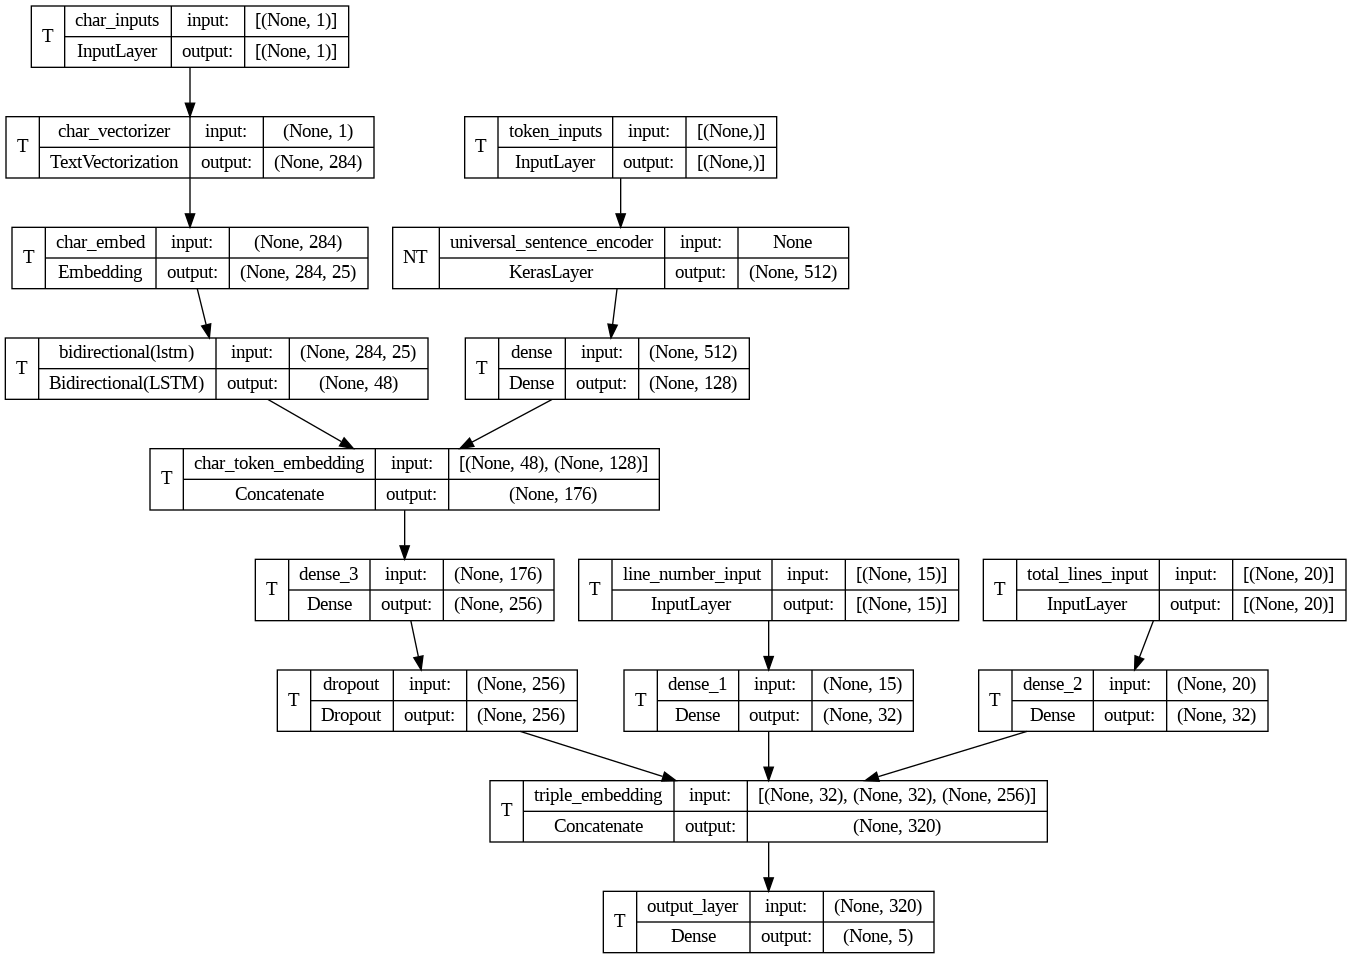

In [44]:
# Plot the architecture
tf.keras.utils.plot_model(model_5,
                          show_shapes=True,
                          show_trainable=True)

In [45]:
# Check the summary of the model
model_5.summary()

Model: "triple_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 284)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_embed (Embedding)         (None, 284, 25)      1500        ['char_vecto

### Prepare datasets for the model

In [46]:
# Train dataset
train_ln_tl_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                  train_total_lines_one_hot,
                                                                  train_chars,
                                                                  train_sentences))
train_ln_tl_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_ln_tl_char_token_dataset = tf.data.Dataset.zip((train_ln_tl_char_token_data,
                                                      train_ln_tl_char_token_labels))
train_ln_tl_char_token_dataset = train_ln_tl_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_ln_tl_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [47]:
# Validation dataset
val_ln_tl_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_chars,
                                                                val_sentences))
val_ln_tl_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_ln_tl_char_token_dataset = tf.data.Dataset.zip((val_ln_tl_char_token_data,
                                                    val_ln_tl_char_token_labels))
val_ln_tl_char_token_dataset = val_ln_tl_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_ln_tl_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Create the callbacks
More specifically: ModelCheckpoint and EarlyStopping.

In [48]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_checkpoint = ModelCheckpoint(filepath="model_5_ckpt",
                                   monitor='val_loss',
                                   verbose=1,
                                   save_weights_only=True,
                                   save_freq='epoch')

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               verbose=1,
                               restore_best_weights=True,
                               start_from_epoch=3)

### Compile the model

In [49]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
history_model_5 = model_5.fit(train_ln_tl_char_token_dataset,
                              #steps_per_epoch=int(0.1*len(train_ln_tl_char_token_dataset)),
                              epochs=10,
                              validation_data=val_ln_tl_char_token_dataset,
                              validation_steps=int(0.1*len(val_ln_tl_char_token_dataset)),
                              callbacks=[model_checkpoint,
                                         early_stopping])

Epoch 1/10
   20/69121 [..............................] - ETA: 6:26:37 - loss: 1.5204 - accuracy: 0.3547